
# Neural Nets Final Project
This project recreates the tutorial code at: https://jovian.ai/ankitvashisht12/dog-breed-classifier-final

File was created/run in Colab.

But has been modified for 2 breeds and not using a validation set for faster speed. Currently, all working code (training, graph outputs, data processing) has been copied and modified from that tutorial at the time of this submission.

At the time of presenting on Dec 12, I hope to have also modified and re-run it to use fewer layers or different parameters (stride, types of pooling) for accuracy comparisons.

To load the images for training and testing, please modify the two filepaths in the next folder to where the test and train images are located (on your drive or locally) as shown below. This can be downloaded from the github repo.

In [ ]:
import torchvision
import torch.nn as nn
import torch.random as rand
from torch.utils.data import Dataset, random_split, DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import torchvision.models as models


# image loading
train = ImageFolder("/content/drive/MyDrive/UNH/2_breeds/img_train")
test = ImageFolder("/content/drive/MyDrive/UNH/2_breeds/img_test")



In [ ]:
random_seed = 45
rand.manual_seed(random_seed);

chihuahua


TypeError: ignored

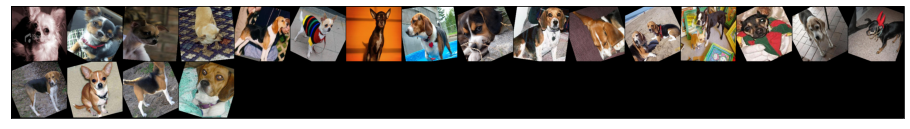

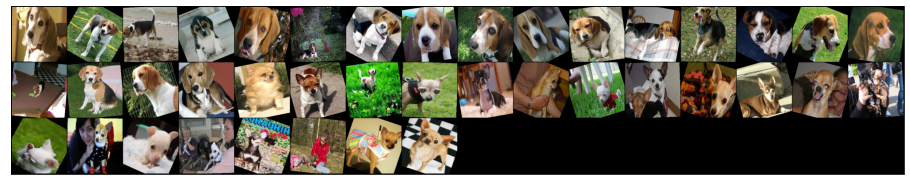

In [ ]:
from torch.nn.modules.loss import TripletMarginWithDistanceLoss
categories = train.classes

img, label = train[200]
print(categories[label])
batchSize=20


# copied from: https://jovian.ai/ankitvashisht12/dog-breed-classifier-final
# custom data loading/resize method
# Modifications: not using separate sizes for train and validate;
# not using validation dataset


# Custom subclass of dataset
class DogBreedDataset(Dataset):
    
    def __init__(self, ds, transform=None):
        self.ds = ds
        self.transform = transform
        
    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, idx):
        img, label = self.ds[idx]
        if self.transform:
            img = self.transform(img)  
            return img, label

train_transform = transforms.Compose([
#    transforms.Resize((224, 224)),
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224, padding=4, padding_mode='reflect'),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(degrees=30),
    transforms.ToTensor(),
#    transforms.Normalize(*imagenet_stats, inplace=True)
    
])

# output the images in batch format, showing how they've been resized and oriented
# for training
def show_batch(dl):
    for img, lb in dl:
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(img.cpu(), nrow=16).permute(1,2,0))
        break

trainDataSet = DogBreedDataset(train, train_transform)
testDataSet = DogBreedDataset(test, train_transform)

trainDL = DataLoader(trainDataSet, batchSize, shuffle=True, num_workers=2)
testDL = DataLoader(testDataSet, batchSize, num_workers=2)

show_batch(trainDL)
show_batch(testDL)





In [ ]:

import torch.nn as nn
from tqdm.notebook import tqdm

# BELOW COPIED https://jovian.ai/ankitvashisht12/dog-breed-classifier-final
class ImageClassificationBase(nn.Module):
    # training step
    def training_step(self, batch):
        img, targets = batch
        out = self(img)
        loss = F.nll_loss(out, targets)
        return loss
    
    # validation step
    def validation_step(self, batch):
        img, targets = batch
        out = self(img)
        loss = F.nll_loss(out, targets)
        acc = accuracy(out, targets)
        return {'val_acc':acc.detach(), 'val_loss':loss.detach()}
    
    # validation epoch end
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss':epoch_loss.item(), 'val_acc':epoch_acc.item()}
        
    # print result end epoch
    def epoch_end(self, epoch, result):
        print("Epoch [{}] : train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result["train_loss"], result["val_loss"], result["val_acc"]))


class DogBreedClassificationCNN(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=1, padding=1),   # 224 * 244 * 32
            nn.ReLU(),                                   
            nn.Conv2d(32, 32, 3, stride=1, padding=1),       
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                         # 112 * 112 * 32
            
            nn.Conv2d(32, 64, 3, stride=1, padding=1),   # 112 * 112* 64
            nn.ReLU(), 
            nn.Conv2d(64, 128, 3, stride=1, padding=1),    # 112 * 112* 128
            nn.ReLU(),
            nn.MaxPool2d(2,2),                          # 56 * 56* 128
            
            nn.Conv2d(128, 256, 3, stride=1, padding=1),   # 56*56*256
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, stride=1, padding=1),  # 56*56*256
            nn.ReLU(), 
            nn.MaxPool2d(2,2),                        # 28*28*256
            
            nn.Conv2d(256, 256, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),                            # 14*14*256
            
            nn.Conv2d(256, 256, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),                            # 7*7*256
            
            nn.Flatten(),
            nn.Linear(7*7*256, 512),
            nn.ReLU(),
            #nn.Linear(512, 120),
            nn.Linear(512, 120),
            nn.LogSoftmax(dim = 1),
        )
    
    def forward(self, xb):
        return self.network(xb)


def try_batch(dl):
    for imgs, labels in dl:
        print("images shape : ", imgs.shape)
        print("labels : ", labels)
        model = DogBreedClassificationCNN()
        outs = model(imgs)  # Change model object here                     
        print("outs.shape :", outs.shape)
        print("outs : ", outs)
        break
        

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

model = DogBreedClassificationCNN()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)



  

images shape :  torch.Size([20, 3, 224, 224])
labels :  tensor([1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0])
outs.shape : torch.Size([20, 120])
outs :  tensor([[-4.7984, -4.7613, -4.8172,  ..., -4.8102, -4.7911, -4.8364],
        [-4.7984, -4.7614, -4.8172,  ..., -4.8102, -4.7912, -4.8365],
        [-4.7984, -4.7613, -4.8172,  ..., -4.8103, -4.7912, -4.8365],
        ...,
        [-4.7984, -4.7613, -4.8173,  ..., -4.8102, -4.7912, -4.8364],
        [-4.7984, -4.7614, -4.8172,  ..., -4.8102, -4.7912, -4.8364],
        [-4.7984, -4.7614, -4.8172,  ..., -4.8103, -4.7911, -4.8365]],
       grad_fn=<LogSoftmaxBackward0>)


In [ ]:
import torch.optim

# set hyperparams
num_epochs = 5
opt_func = torch.optim.SGD

max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4

model.train()       
train_losses = []
lrs = []
history = []
optimizer = opt_func(model.parameters(), lr=0.01)
epochs=20
for epoch in range(epochs):
  for batch in tqdm(trainDL):
      loss = model.training_step(batch)
      train_losses.append(loss)
      
      # calculates gradients
      loss.backward()
          
      # perform gradient descent and modifies the weights
      optimizer.step()
      
      # reset the gradients
      optimizer.zero_grad()
      
      # record and update lr
      #lrs.append(get_lr(optimizer))
      
      # modifies the lr value
      #sched.step()
      
  # Validation phase
  result = evaluate(model, testDL)
  result['train_loss'] = torch.stack(train_losses).mean().item()
  result['lrs'] = lrs
  model.epoch_end(epoch, result)
  history.append(result)

  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [0] : train_loss: 4.7428, val_loss: 4.6890, val_acc: 0.5000


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [1] : train_loss: 4.6902, val_loss: 4.5825, val_acc: 0.5000


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [2] : train_loss: 4.6335, val_loss: 4.4520, val_acc: 0.5000


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [3] : train_loss: 4.5645, val_loss: 4.2329, val_acc: 0.5000


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [4] : train_loss: 4.4399, val_loss: 3.2590, val_acc: 0.5000


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [5] : train_loss: 3.9136, val_loss: 0.8159, val_acc: 0.5000


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [6] : train_loss: 3.4604, val_loss: 0.7033, val_acc: 0.5000


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [7] : train_loss: 3.1191, val_loss: 0.8164, val_acc: 0.5000


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [8] : train_loss: 2.8549, val_loss: 1.0011, val_acc: 0.5000


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [9] : train_loss: 2.6453, val_loss: 0.7250, val_acc: 0.5000


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [10] : train_loss: 2.4729, val_loss: 0.8542, val_acc: 0.5000


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [11] : train_loss: 2.3274, val_loss: 1.0237, val_acc: 0.5000


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [12] : train_loss: 2.2055, val_loss: 0.8116, val_acc: 0.5000


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [13] : train_loss: 2.0992, val_loss: 0.8528, val_acc: 0.5000


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [14] : train_loss: 2.0094, val_loss: 0.7973, val_acc: 0.5000


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [15] : train_loss: 1.9289, val_loss: 0.7069, val_acc: 0.5000


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [16] : train_loss: 1.8582, val_loss: 0.7080, val_acc: 0.5000


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [17] : train_loss: 1.7944, val_loss: 0.7067, val_acc: 0.5000


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [18] : train_loss: 1.7391, val_loss: 0.7150, val_acc: 0.5000


  0%|          | 0/16 [00:00<?, ?it/s]

Epoch [19] : train_loss: 1.6871, val_loss: 0.9429, val_acc: 0.5000


In [ ]:
result = evaluate(model, testDL)
result['train_loss'] = torch.stack(train_losses).mean().item()
result['lrs'] = lrs
model.epoch_end(12, result)
history.append(result)

Epoch [12] : train_loss: 1.6871, val_loss: 0.9395, val_acc: 0.5000


In [ ]:
print(history)

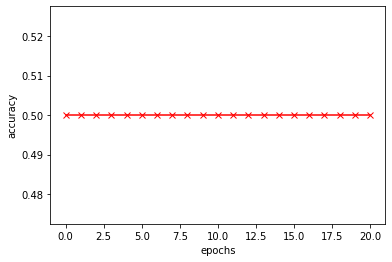

In [ ]:
val_loss = []
train_loss = []
val_acc = []
time = list(range(len(history)))
for h in history:
    val_loss.append(h['val_loss'])
    train_loss.append(h['train_loss'])
    val_acc.append(h['val_acc'])

plt.plot(time, val_acc, c='red', label='accuracy', marker='x')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()


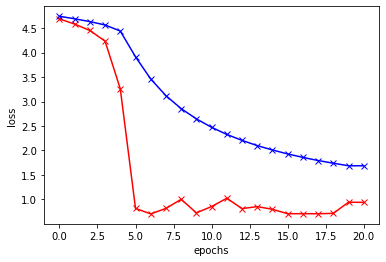

In [ ]:
plt.plot(time, val_loss, c='red', label='val_loss', marker='x')
plt.plot(time, train_loss, c='blue', label='train_loss', marker='x')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [1]:
def predict_single(img, label):
   # xb = img.unsqueeze(0) # adding extra dimension
    #xb = to_device(xb, device)
    preds = model(img)                   # change model object here
    predictions = preds[0]
    
    max_val, kls = torch.max(predictions, dim=0)
    print('Actual :', breeds[label], ' | Predicted :', breeds[kls])
    plt.imshow(img.permute(1,2,0))
    plt.show()



#output = predict_single(testDL.getitem(0), label2)

NameError: ignored

In [ ]:


def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss


  train_one_epoch

In [ ]:

import torch

model = DogBreedClassificationCNN()
criterion = nn.MSELoss() # the loss function
optimizer = torch.optim.Adam(model.parameters()) # Optimizer 

# training loop
n_epochs = 10 
for i in range(n_epochs):
    y_hat = model(trainDL)           # make a prediction with current parameters
    loss = criterion(y_hat, y) # compute loss 
    optimizer.zero_grad()      # this and next three lines will perform one gradient step
    loss.backward()
    optimizer.step()